In [1]:
import pymysql

import pandas as pd
import logging
import warnings
warnings.filterwarnings("ignore")

import os
import sys
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

import numpy as np
np.random.seed(42)

from datetime import datetime, timedelta
import pickle

def mape_not_zero(y_true, y_pred):
    mape = 0
    for t, p in zip(y_true, y_pred):
        if t != 0:
            mape += np.abs((t - p) / t)
        elif p != 0:
            mape += np.abs((t - p) / p)

    mape /= len(y_true)
    return np.mean(mape) * 100

def rmse(y_true, y_pred):
    mse = (np.square(y_true - y_pred)).mean(axis=0)
    return np.sqrt(mse) 

In [2]:
# from sklearn.preprocessing import MinMaxScaler

# scaler=MinMaxScaler()
# df = pd.read_csv("/Users/kjh001/z_eggo/weather.csv", encoding='cp949')
# scale_cols=['temp','humi','wind','vol']
# df_scaled_temp=scaler.fit_transform(df['temp'])
# df_scaled_humi=scaler.fit_transform(df['humi'])
# df_scaled_wind=scaler.fit_transform(df['wind'])
# df_scaled_vol=scaler.fit_transform(df['vol'])

# df_scaled=pd.DataFrame(df_scaled_temp,df_scaled_humi,df_scaled_wind,df_scaled_vol)
# df_scaled.columns=scale_cols
# # print(df_scaled)


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df = pd.read_csv("/Users/kjh001/z_eggo/weather.csv", encoding='cp949')
scale_cols=['temp','humi','wind','vol']
df_scaled=scaler.fit_transform(df[scale_cols])


df_scaled=pd.DataFrame(df_scaled)
df_scaled.columns=scale_cols
print(df_scaled)


          temp    humi      wind       vol
0     0.200000  0.5625  0.289941  0.243946
1     0.200000  0.5625  0.289941  0.244930
2     0.200000  0.5625  0.289941  0.251231
3     0.200000  0.5625  0.289941  0.244733
4     0.155556  0.6875  0.106509  0.240992
...        ...     ...       ...       ...
8755  0.177778  0.5625  0.195266  0.011223
8756  0.177778  0.5625  0.195266  0.012404
8757  0.177778  0.5625  0.195266  0.011223
8758  0.155556  0.6875  0.153846  0.011026
8759  0.155556  0.6875  0.153846  0.010238

[8760 rows x 4 columns]


In [4]:
train=df_scaled[:7008]
test=df_scaled[7008:]

In [5]:
def make_dataset(data,label,size=2):
    feature_list=[]
    label_list=[]
    for i in range(len(data)-size):
        feature_list.append(np.array(data.iloc[i:i+size]))
        label_list.append(np.array(label.iloc[i+size]))
    return np.array(feature_list),np.array(label_list)

In [6]:
feature_cols=['temp','humi','wind']
label_cols=['vol']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature,train_label,2)

from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid=train_test_split(train_feature,train_label,test_size=0.2)
print(x_train.shape, x_valid.shape)

test_feature, test_label = make_dataset(test_feature,test_label,2)
print(test_feature.shape, test_label.shape)

(5604, 2, 3) (1402, 2, 3)
(1750, 2, 3) (1750, 1)


In [7]:
# model=Sequential()
# model.add(LSTM(32,
#                input_shape=(train_feature.shape[1],train_feature.shape[2]),
#                activation='relu',return_sequences=False))
# model.add(Dense(1))
# model.summary()

In [8]:
model=Sequential()
model.add(GRU(32, batch_input_shape=(1, 2, 3),
              stateful=True, return_sequences=True,
              dropout=.1, recurrent_dropout=.2))  
model.add(GRU(16, stateful=True,
              dropout=.2, recurrent_dropout=.5))  
model.add(Dense(1))
model.summary()

Metal device set to: Apple M1


2022-05-25 00:17:42.248103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 00:17:42.248335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (1, 2, 32)                3552      
                                                                 
 gru_1 (GRU)                 (1, 16)                   2400      
                                                                 
 dense (Dense)               (1, 1)                    17        
                                                                 
Total params: 5,969
Trainable params: 5,969
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='mse',optimizer='adam')
early_stop=EarlyStopping(monitor='val_loss',patience=10,verbose=1)
history=model.fit(x_train,y_train,epochs=100,
                  batch_size=1, verbose=1,
                  validation_data=(x_valid,y_valid),
                  callbacks=[early_stop])

Epoch 1/100


2022-05-25 00:17:42.843158: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-25 00:17:46.466421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5604/5604 [==============================] - ETA: 0s - loss: 0.0058

2022-05-25 00:27:14.595225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5604/5604 [==============================] - 611s 108ms/step - loss: 0.0058 - val_loss: 0.0642
Epoch 2/100
5604/5604 [==============================] - 716s 128ms/step - loss: 0.0050 - val_loss: 0.0553
Epoch 3/100
5604/5604 [==============================] - 692s 123ms/step - loss: 0.0048 - val_loss: 0.0397
Epoch 4/100
5604/5604 [==============================] - 657s 117ms/step - loss: 0.0048 - val_loss: 0.0178
Epoch 5/100
5604/5604 [==============================] - 537s 96ms/step - loss: 0.0047 - val_loss: 0.0121
Epoch 6/100
5604/5604 [==============================] - 537s 96ms/step - loss: 0.0047 - val_loss: 0.0111
Epoch 7/100
5604/5604 [==============================] - 447s 80ms/step - loss: 0.0047 - val_loss: 0.0069
Epoch 8/100
5604/5604 [==============================] - 358s 64ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 9/100
5604/5604 [==============================] - 382s 68ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 10/100
5604/5604 [==============================

In [10]:
testmse = model.evaluate(test_feature, test_label, batch_size=1)
testmse

1750/1750 [==============================] - 30s 17ms/step - loss: 0.0164


0.016352467238903046

In [29]:
pred=model.predict(test_feature,batch_size=1)

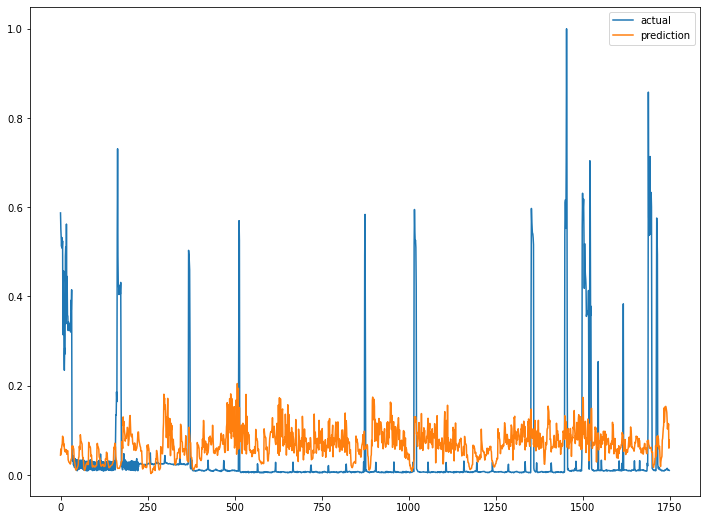

In [30]:
plt.figure(figsize=(12,9))
plt.plot(test_label,label='actual')
plt.plot(pred,label='prediction')
plt.legend()
plt.show()

In [31]:
pkl_path = "model/model_rnn_eggo_gru.pkl"
with open(pkl_path, "wb") as f:
    pickle.dump(model, f)

2022-05-26 13:55:57.200500: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://e9d296a7-0843-4caf-8e02-f0d97587f62c/assets
